In [1]:
import torch
from matplotlib import pyplot as plt
from torch.optim import Adam
from gpytorch.optim import NGD

from alfi.models import generate_multioutput_rbf_gp
from alfi.plot import Plotter1d
from alfi.utilities.torch import softplus
from alfi.impl.odes import RNAVelocityLFM, RNAVelocityConfiguration
from alfi.datasets import SingleCellKidney, Pancreas
from alfi.impl.trainers import EMTrainer

import numpy as np

In [2]:
# kidney_path = '/Volumes/ultra/genomics/scRNA-seq/GSE131685_RAW_kidney/velocyto'
# kidney_path = 'F:/genomics/scRNA-seq/GSE131685_RAW_kidney/velocyto'
#
# dataset = SingleCellKidney(calc_moments=True, raw_data_dir=kidney_path)
dataset = Pancreas(data_dir='../../data')
print(dataset.m_observed.shape)
print(dataset.gene_names.shape)
print(dataset[0].shape)
cpe_index = np.where(dataset.loom.var.index == 'Cpe')[0][0]

torch.Size([1, 4000, 3696])
(2000,)
torch.Size([1, 3696])


In [3]:
def print_scatter(cells, gene_index, num_connections=10, colors=None):
    traj = lfm.current_trajectory
    u = traj[:2000].detach()  # (num_genes, 100)
    s = traj[2000:].detach()  # (num_genes, 100)
    u_y = cells[:2000]  # (num_genes, num_cells)
    s_y = cells[2000:]  # (num_genes, num_cells)

    plt.figure(figsize=(3, 3))
    plt.title(dataset.gene_names[gene_index])

    # Plot trajectory
    plt.plot(s[gene_index], u[gene_index], color='red')

    # Plot cell points
    indices = np.intersect1d(s_y[gene_index, :, 0].nonzero(),
                             u_y[gene_index, :, 0].nonzero())
    plt.scatter(s_y[gene_index, indices, 0], u_y[gene_index, indices, 0], alpha=0.1,s=5, c='black')

    # Plot timepoint choices
    for timepoint in range(lfm.timepoint_choices.shape[0]):
        plt.scatter(s[gene_index, timepoint], u[gene_index, timepoint], s=4, c='black')

    # Plot some connections between cell points and the trajectory line
    for i in range(num_connections):
        plt.scatter(s_y[gene_index, i, 0], u_y[gene_index, i, 0], s=8, c='red')
        line = [
            (s[gene_index, lfm.time_assignments_indices[i]], s_y[gene_index, i, 0]),
            (u[gene_index, lfm.time_assignments_indices[i]], u_y[gene_index, i, 0])
        ]
        plt.plot(line[0], line[1], alpha=0.5, c='purple')
        # trainer.time_assignments_indices[i]
    plt.ylabel('unspliced')
    plt.xlabel('spliced')

In [4]:
num_cells = dataset[0].shape[1]
num_latents = 10
num_inducing = 50  # (I x m x 1)
end_t = 12
use_natural = False

config = RNAVelocityConfiguration(
    num_samples=30,
    num_cells=num_cells,
    end_pseudotime=end_t
)

print('Number of cells:', num_cells)
print('Number of latent GPs (# transcription rates):', num_latents)

step_size = 1e-1

inducing_points = torch.linspace(0, end_t, num_inducing).repeat(num_latents, 1).view(num_latents, num_inducing, 1)
t_predict = torch.linspace(0, end_t, 80, dtype=torch.float32)

gp_model = generate_multioutput_rbf_gp(num_latents, inducing_points,
                                       use_scale=False, initial_lengthscale=3,
                                       gp_kwargs=dict(natural=use_natural))

Number of cells: 3696
Number of latent GPs (# transcription rates): 10


In [5]:
data = dataset.m_observed.squeeze()
print(data.shape)
y_target = data
u_y = y_target[:2000]  # (num_genes, num_cells)
s_y = y_target[2000:]  # (num_genes, num_cells)
# w = torch.logical_and(u_y > 0, s_y > 0)
# u_y = torch.gather(u_y, dim=1, index=w)
print(s_y.shape)
x = s_y > torch.tensor(np.percentile(s_y, 98, axis=1)).unsqueeze(-1)
s = s_y * x
x = u_y > torch.tensor(np.percentile(u_y, 98, axis=1)).unsqueeze(-1)
u = u_y * x

torch.Size([4000, 3696])
torch.Size([2000, 3696])


In [6]:
# s_sort_ind = s_y.argsort(dim=1)
# u_sort_ind = u_y.argsort(dim=1)
# s_low = torch.gather(s_y, dim=1, index=s_sort_ind[:, :50]) + 1e-5
# s_high = torch.gather(s_y, dim=1, index=s_sort_ind[:, -50:])
# u_low = torch.gather(u_y, dim=1, index=u_sort_ind[:, :50]) + 1e-5
# u_high = torch.gather(u_y, dim=1, index=u_sort_ind[:, -50:])
# s = torch.cat([s_low, s_high], dim=1).unsqueeze(-1)
# u = torch.cat([u_low, u_high], dim=1).unsqueeze(1)

s = s.unsqueeze(-1)
u = u.unsqueeze(1)
gamma = torch.matmul(u, s).squeeze()
l2 = s.squeeze().square().sum(dim=1)
gamma /= l2
gamma = gamma.unsqueeze(-1)
print(gamma.max(), gamma.min())

lfm = RNAVelocityLFM(4000, gp_model, config, nonlinearity=softplus, decay_rate=gamma, num_training_points=num_cells)
if use_natural:
    variational_optimizer = NGD(lfm.variational_parameters(), num_data=num_cells, lr=0.05)
    parameter_optimizer = Adam(lfm.nonvariational_parameters(), lr=0.02)
    optimizers = [variational_optimizer, parameter_optimizer]
else:
    optimizers = [torch.optim.Adam(lfm.parameters(), lr=0.06)]
trainer = EMTrainer(lfm, optimizers, dataset, batch_size=4000)
plotter = Plotter1d(lfm, dataset.gene_names)

tensor(37.4716) tensor(0.)
torch.Size([30, 2000, 362]) a 200 10 4000


### Outputs prior to training:

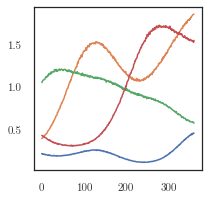

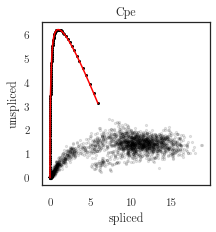

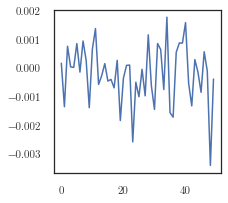

In [7]:
t = inducing_points
t_f = torch.arange(t.min(), t.max()+step_size/3, step_size/3)
num_samples = 4
s = lfm.sample_latents(t_f, num_samples)
plt.figure(figsize=(3, 3))
for sample in range(num_samples):
    plt.plot(s[sample, :, 0].detach())

data = next(iter(trainer.data_loader))
cells = data.permute(0, 2, 1) # (O, C, 1)
print_scatter(cells, cpe_index, num_connections=0)
plt.figure(figsize=(3, 3))
mean = list(lfm.gp_model.variational_parameters())[0]
plt.plot(mean.detach()[0])

In [ ]:

import time
start = time.time()

output = trainer.train(10, report_interval=1, step_size=1e-1)
end = time.time()
print(end - start)

estep done
num t: torch.Size([64])
torch.Size([30, 2000, 362]) a 200 10 4000
back


In [ ]:
savefile = './rna-0806'

lfm.save(savefile)

In [9]:
savefile = './rna-0806'

do_load = True
if do_load:
    lfm_kwargs = dict(num_training_points=num_cells)
    lfm = RNAVelocityLFM.load(savefile,
                              gp_model=gp_model,
                              lfm_args=[lfm.num_outputs, config],
                              lfm_kwargs=lfm_kwargs)


    optimizer = torch.optim.Adam(lfm.parameters(), lr=0.1)
    trainer = EMTrainer(lfm, [optimizer], dataset, batch_size=4000)
print(do_load)

torch.Size([30, 2000, 362]) a 200 10 4000
True


torch.Size([30, 2000, 362]) a 200 10 4000


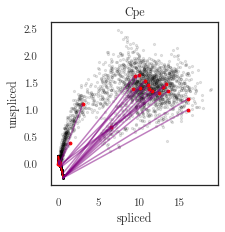

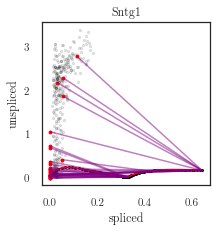

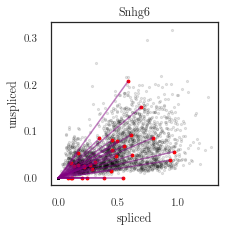

In [13]:
#0, -3 15
#0 -2 0 3
lfm(lfm.timepoint_choices, step_size=step_size)

# plotter.plot_outputs(t_predict, replicate=0, t_scatter=t_observed,y_scatter=dataset.m_observed, model_kwargs=model_kwargs);
# plotter.plot_latents(t_predict, ylim=(-1, 3), plot_barenco=True, plot_inducing=False)

for i in [cpe_index] + list(range(0, 2)):
    print_scatter(cells, i, num_connections=30)

In [ ]:

# with torch.no_grad():
#     # lfm.splicing_rate[cpe_index] += 0.2
#     lfm.transcription_rate[cpe_index] += 0.5
print(lfm.time_assignments_indices)
print(lfm.decay_rate[cpe_index])
print(lfm.splicing_rate[cpe_index])
print(lfm.transcription_rate[cpe_index])

In [ ]:
print(l2[cpe_index])
print(gamma.shape)
print(gamma.min())
print(gamma.max())
# s_low = s_y[s_sort_ind[-50:]]
# print(s_low)
# u_y.shape, s_y.shape

In [ ]:
print(y_target.shape)
print(lfm.current_trajectory.shape)
u = lfm.current_trajectory[:2000].detach()[cpe_index]
s = lfm.current_trajectory[2000:].detach()[cpe_index]
u_y = y_target[:2000][cpe_index]  # (num_genes, num_cells)
s_y = y_target[2000:][cpe_index]  # (num_genes, num_cells)
print(u.shape, u_y.shape)
plt.scatter(u, s)
plt.scatter(u_y, s_y)

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(5, 2))
axes[0].plot(u[:, cpe_index])
axes[1].plot(s[:, cpe_index])


### Outputs after training

In [ ]:
plotter.plot_losses(trainer, last_x=100)

for i in range(0, 50, 2):
    print_scatter(cells, i, num_connections=0)

In [ ]:
traj = lfm.current_trajectory.mean.transpose(0, 1)
u = traj[:2000].detach().unsqueeze(2)  # (num_genes, 100, 1)
s = traj[2000:].detach().unsqueeze(2)  # (num_genes, 100, 1)
u_y = cells[:2000]  # (num_genes, num_cells)
s_y = cells[2000:]  # (num_genes, num_cells)
print(s_y.shape, s.transpose(1, 2).shape)
u_residual = u_y[:, :1000] - u.transpose(1, 2)
s_residual = s_y[:, :1000] - s.transpose(1, 2)
print(u_residual.shape) # (genes, cells, timepoints)
residual = u_residual.square() + s_residual.square()
# residual = residual.sum(dim=0).argmin(dim=1).type(torch.long)
gene_index = 0
residual = residual[gene_index]
print(residual.shape)
residual_indices = residual.argmin(dim=1)
print(residual_indices.shape)
residual_minimum = residual.min(dim=1).values
print('min', residual_minimum.shape)
residual_sort_indices = residual_minimum.argsort(descending=True)
# print(residual_sort_indices)
# for this gene, the indices of the closest timepoint for all cells

# Plot trajectory
plt.scatter(s[gene_index], u[gene_index])

# Plot cell points
indices = np.intersect1d(s_y[gene_index, :, 0].nonzero(),
                         u_y[gene_index, :, 0].nonzero())
plt.scatter(s_y[gene_index, indices, 0], u_y[gene_index, indices, 0], s=5, c='black')

for cell_index in residual_sort_indices[:100]:
    plt.scatter(s_y[gene_index, cell_index, 0], u_y[gene_index, cell_index, 0], s=8, c='red')
    line = [
    (s[gene_index, residual_indices[cell_index]], s_y[gene_index, cell_index, 0]),
    (u[gene_index, residual_indices[cell_index]], u_y[gene_index, cell_index, 0])
    ]
    plt.plot(line[0], line[1], alpha=0.8, c='purple')
# plt.xlim(0.015, 0.071)
# plt.ylim(0.22, 0.25)

In [ ]:
n
import scvelo as scv
scv.tl.velocity(dataset.loom)

In [ ]:
scv.pl.velocity(dataset.loom, ['Cpe',  'Gnao1', 'Ins2', 'Adk'], ncols=2)

In [ ]:
velocity = dataset.loom.layers['velocity']
print(velocity[:100, cpe_index].shape)